In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
# import lightgbm as lgb
# import featuretools as ft

import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [2]:
SEED = 37
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED) 

# Read Train Data

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [27]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

# Pre-processing

In [30]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [34]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
train_x = pd.DataFrame(train_x).fillna(0)
test_x = pd.DataFrame(test_x).fillna(0)

In [35]:
def split_data(df):
    """
    Split data into training and validation sets based on the distribution of the y class.

    Parameters:
    df (pandas.DataFrame): dataframe with a column named "y" containing the class labels.

    Returns:
    train_idx (list): list of indexes for the training set.
    val_idx (list): list of indexes for the validation set.
    """
    # create empty lists to store indexes
    train_idx = []
    val_idx = []

    # loop through each y class
    for c in df['Y_Class'].unique():
        # get indexes for this class
        idx = df[df['Y_Class'] == c].index

        # split indexes into training and validation sets
        t, v = train_test_split(idx, test_size=0.2, random_state=SEED)

        # add training and validation indexes to the lists
        train_idx += list(t)
        val_idx += list(v)

    # shuffle the indexes to ensure randomness
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)

    return train_idx, val_idx
# for permutation importance check
t_idx, v_idx = split_data(train_df) 
# train_x = train_x.drop(columns = ['Y_Class'])
X_train, X_test, y_train, y_test = train_x.iloc[t_idx],train_x.iloc[v_idx],train_y.iloc[t_idx],train_y.iloc[v_idx]

print (f'X_train:{X_train.shape} y_train: {y_train.shape}')
print (f'X_test:{X_test.shape} y_test: {y_test.shape}')

X_train:(477, 2877) y_train: (477,)
X_test:(121, 2877) y_test: (121,)


In [36]:
# # for permutation importance check 
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.15, random_state = SEED)
# print (f'X_train:{X_train.shape} y_train: {y_train.shape}')
# print (f'X_test:{X_test.shape} y_test: {y_test.shape}')

# CatBoost

In [37]:
from sklearn.feature_selection import VarianceThreshold
X = X_train
selector = VarianceThreshold()
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X)
print("Transformed feature shape:", new_X.shape)

#The output shows that 
#the transformed features are the same shape so all features have at least some variance.

Original feature shape: (477, 2877)
Transformed feature shape: (477, 2429)


In [38]:
new_test_x = selector.transform(test_x) # infer
new_x_test = selector.transform(X_test) # train

In [39]:
new_test_x.shape,new_x_test.shape

((310, 2429), (121, 2429))

In [40]:
from catboost import Pool, CatBoostClassifier, cv

In [41]:
model = CatBoostClassifier(l2_leaf_reg=3.5,
                         depth= 11, boosting_type='Plain',  
                          use_best_model=True
                           ,random_seed=SEED,bootstrap_type= "Bernoulli")

In [42]:
# cate_features_index = np.where(new_X.dtypes != float)[0]


In [43]:
model.fit(new_X, y_train,eval_set=(new_x_test, y_test))


0:	learn: 1.0765284	test: 1.0822630	best: 1.0822630 (0)	total: 5.57s	remaining: 1h 32m 42s
1:	learn: 1.0558602	test: 1.0663491	best: 1.0663491 (1)	total: 11.1s	remaining: 1h 32m 15s
2:	learn: 1.0367309	test: 1.0520342	best: 1.0520342 (2)	total: 16.4s	remaining: 1h 31m 2s
3:	learn: 1.0183818	test: 1.0396015	best: 1.0396015 (3)	total: 21.7s	remaining: 1h 30m 7s
4:	learn: 0.9998970	test: 1.0259689	best: 1.0259689 (4)	total: 26.9s	remaining: 1h 29m 4s
5:	learn: 0.9842828	test: 1.0148681	best: 1.0148681 (5)	total: 31.8s	remaining: 1h 27m 54s
6:	learn: 0.9679574	test: 1.0034800	best: 1.0034800 (6)	total: 33s	remaining: 1h 18m 2s
7:	learn: 0.9534486	test: 0.9934938	best: 0.9934938 (7)	total: 38.1s	remaining: 1h 18m 48s
8:	learn: 0.9392494	test: 0.9843459	best: 0.9843459 (8)	total: 43.1s	remaining: 1h 19m 6s
9:	learn: 0.9277785	test: 0.9752609	best: 0.9752609 (9)	total: 48s	remaining: 1h 19m 11s
10:	learn: 0.9154624	test: 0.9664454	best: 0.9664454 (10)	total: 48.5s	remaining: 1h 12m 43s
11:	le

In [44]:
pred = model.predict(test_x)


In [45]:
for i in range(3):
    print(len(pred[pred == i]))

0
310
0


# Hyper Param

In [33]:
import optuna

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [34]:
X = all_train_data.iloc[:,:].to_numpy()
# X = all_train_data
y = y_train.copy()
def objective(trial):
#     train_x, valid_x, train_y, valid_y = train_test_split(all_train_data,y_train, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = CatBoostClassifier(**param)

#     gbm.fit(train_x, train_y, cat_features=cate_features_index, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#     preds = gbm.predict(valid_x)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
    '''cross-validation'''
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X,y):
        X_train, X_valid = X[train_index], X[test_index]
        # X_train = pd.DataFrame(X_train)
        # X_train[[0,1]]=X_train[[0,1]].astype('int') 
        # X_valid = pd.DataFrame(X_valid)
        # X_valid[[0,1]]=X_valid[[0,1]].astype('int') 
        y_train, y_valid = y[train_index], y[test_index]
        clf = CatBoostClassifier(**param)
        clf.fit(X_train, y_train, cat_features=[0,1],eval_set=[(X_valid, y_valid)], verbose=0)
        y_pred_test = clf.predict(X_valid)
        y_pred_test=y_pred_test.round(0).astype(int)
        score = f1_score(y_pred_test,y_valid)
        CV_score_array.append(score)
    avg = np.mean(CV_score_array)
#     return accuracy
    return avg

In [35]:

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, timeout=600)

In [36]:

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

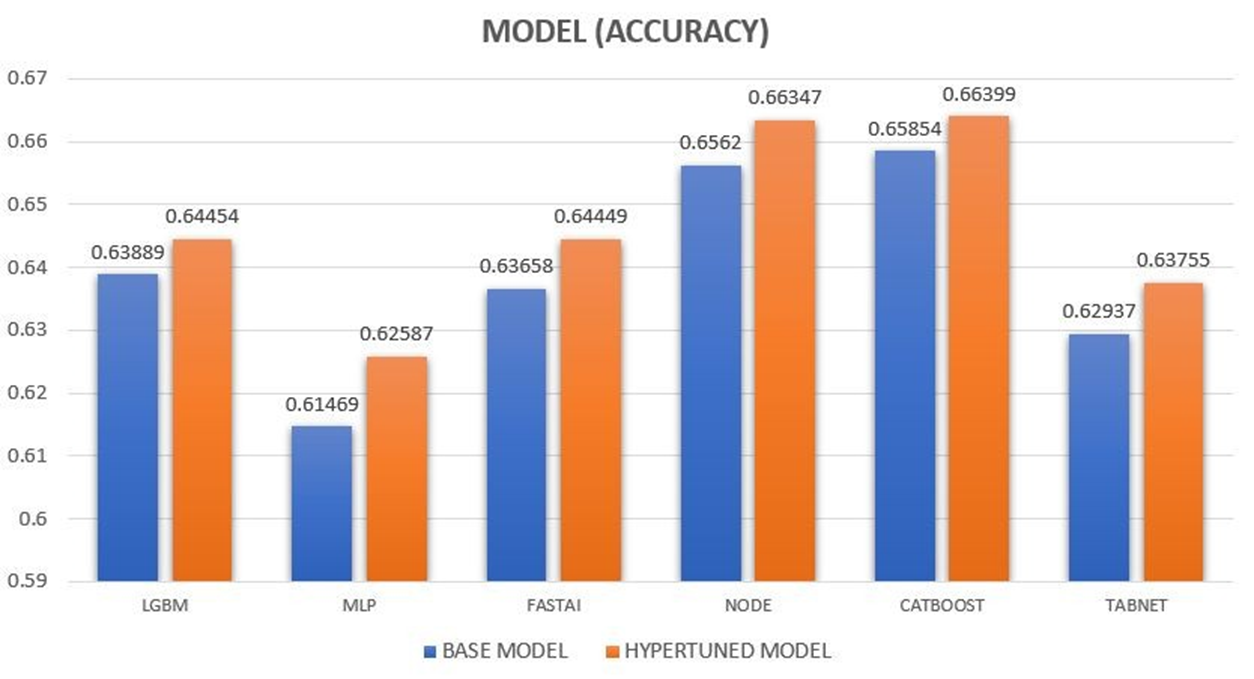

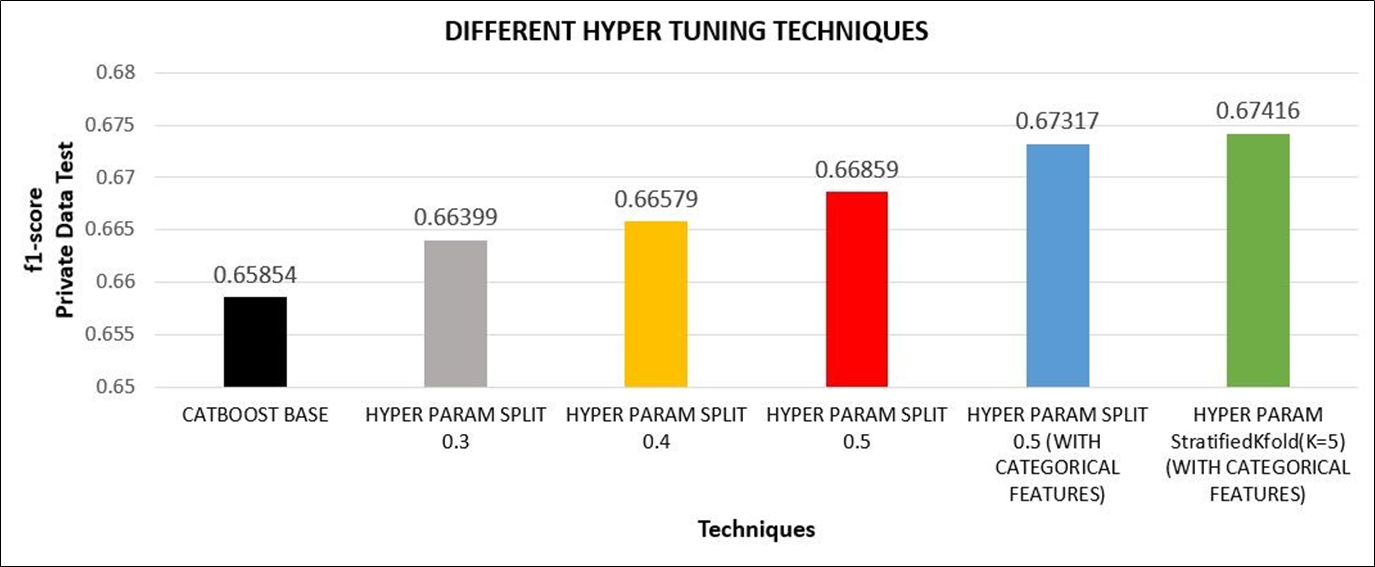


# Conclusions

1. CATBOOST has the highest accuracy  among all the models.
2. CATBOOST has beneﬁt on the robustness of using categorical data  features.
3. Only using 4 features, our technique/model is able to achieved  a fast yet high and comparable  accuracy on leaderboard.
4. Not much features could be used rawly. To get higher accuracy In the  future, Well feature engineering is  required to apply on dataset.
